In [ ]:
# Colab에 Mecab 설치 ( 형태소 분석기 Mecab )
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 91 (delta 43), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (91/91), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
     |████████████████████████████████| 19.4 MB 67.4 MB/s 
     |████████████████████████████████| 86 kB 5.1 MB/s 
     |████████████████████████████████| 448 kB 51.4 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-08-11 12:00:54--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff0

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. 데이터 로드하기 ( 다른 데이터도 시도해보자 )

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")


('ratings_total.txt', <http.client.HTTPMessage at 0x7f107b9921d0>)

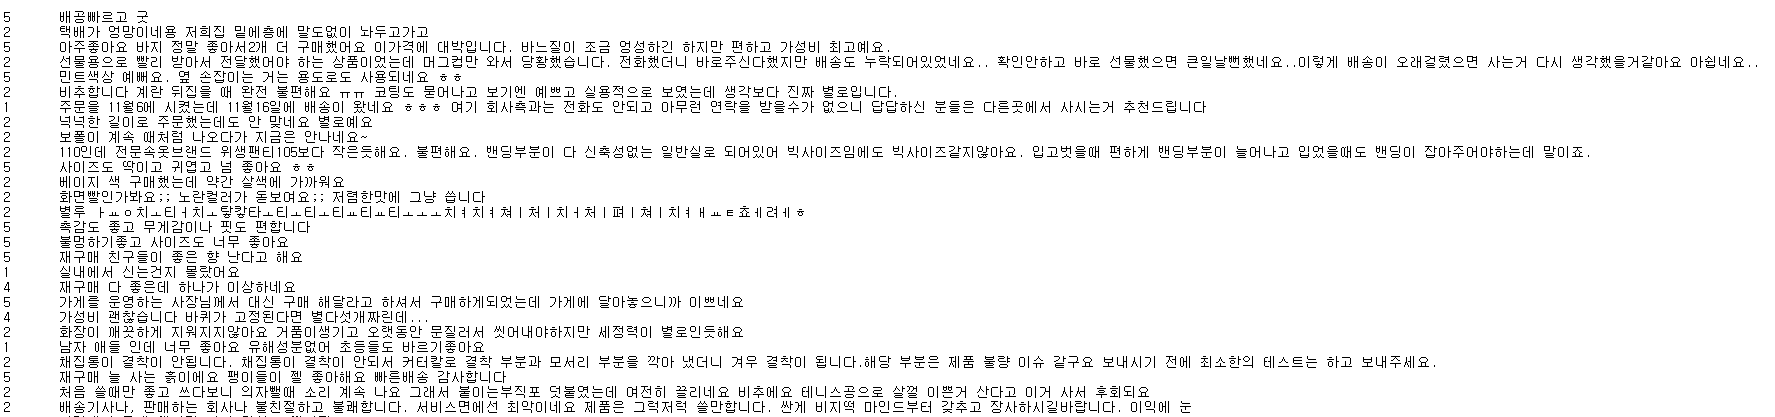

In [ ]:
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 200000


In [ ]:
total_data.head()

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


# 2. 훈련 데이터와 테스트 데이터 분리하기

* 평점 4,5 -> 레이블 1 (긍정)
* 평점 1,2 -> 레이블 0 (부정)

In [ ]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [ ]:
# 각 열에 대해서 중복을 제외한 샘플의 수를 카운트
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

In [ ]:
# reviews 열에서 중복인 샘플들이 존재하므로, 중복인 샘플들을 제거해준다.
total_data.drop_duplicates(subset=['reviews'],inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거.
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 199908


In [ ]:
print(total_data.isnull().values.any()) # NULL 값의 유무 확인

False


In [ ]:
# 훈련 데이터와 테스트 데이터를 4:1 비율로 분리
train_data, test_data = train_test_split(total_data, test_size = 0.2, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 159926
테스트용 리뷰의 개수 : 39982


# 3. 레이블의 분포 확인

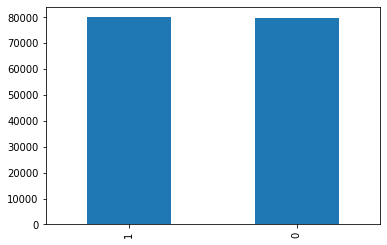

In [ ]:
train_data['label'].value_counts().plot(kind='bar')

In [ ]:
print(train_data.groupby('label').size().reset_index(name='count'))

   label  count
0      0  79923
1      1  80003


# 4. 데이터 정제하기

In [ ]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

ratings    0
reviews    0
label      0
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [ ]:
train_data.isnull().values.any()

False

In [ ]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

In [ ]:
test_data.isnull().values.any()

False

In [ ]:
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 39982


# 5. 토큰화

In [ ]:
mecab=Mecab()
print(mecab.morphs('와 이런것도 상품이라고 차라리 내가 만드는 게 나을 뻔ㅋㅋㅋ')) # 임의의 문장에 대해서 테스트한 토큰화 결과.
print(mecab.morphs('쩔떄 싸찌마요 쓰례끼 쌍품임 ㅋㅋ'))

['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔', 'ㅋㅋㅋ']
['쩔', '떄', '싸', '찌', '마요', '쓰', '례', '끼', '쌍', '품', '임', 'ㅋㅋ']


In [ ]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [ ]:
train_data['tokenized']=train_data['reviews'].apply(mecab.morphs)
train_data['tokenized']=train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
test_data['tokenized']=test_data['reviews'].apply(mecab.morphs)
test_data['tokenized']=test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

# 6. 단어와 길이 분포 확인하기

* 긍정 리뷰에서는 주로 어떤 단어들이 많이 등장하고, 부정 리뷰에는 주로 어떤 단어들이 등장하는지 두 가지 경우에 대해서 각 단어의 빈도수를 계산해보겠습니다. 각 레이블에 따라서 별도로 단어들의 리스트를 저장해줍니다.

In [ ]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [ ]:
# Counter()를 사용하여 각 단어에 대한 빈도수를 카운트합니다. 우선 부정 리뷰에 대해서 빈도수가 높은 상위 20개 단어들을 출력합니다.
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('네요', 33938), ('는데', 21612), ('안', 21038), ('어요', 15738), ('있', 14011), ('너무', 13978), ('했', 12531), ('좋', 10461), ('배송', 10313), ('같', 9553), ('구매', 9456), ('어', 9427), ('거', 9406), ('없', 9264), ('아요', 9220), ('습니다', 9013), ('되', 8909), ('그냥', 8883), ('잘', 8600), ('않', 8481)]


In [ ]:
# Counter()를 사용하여 각 단어에 대한 빈도수를 카운트합니다. 우선 긍정 리뷰에 대해서 빈도수가 높은 상위 20개 단어들을 출력합니다.
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('좋', 42111), ('아요', 22556), ('네요', 21253), ('어요', 19976), ('잘', 19939), ('구매', 17275), ('습니다', 14268), ('있', 13236), ('배송', 13066), ('는데', 12467), ('했', 10518), ('합니다', 10468), ('먹', 10311), ('재', 9925), ('너무', 9007), ('같', 8372), ('만족', 7767), ('거', 6932), ('쓰', 6742), ('어', 6722)]


124757     6
137655     7
187446    10
45529      8
127037    13
          ..
175266     4
112749     4
168324    32
146908    19
121984     8
Name: tokenized, Length: 80003, dtype: int64
긍정 리뷰의 평균 길이 : 13.60208992162794
132466    22
188461    34
50357      9
25326      7
104528     6
          ..
54890     31
110289    26
119904    53
103714    23
131960     7
Name: tokenized, Length: 79923, dtype: int64
부정 리뷰의 평균 길이 : 17.02471128461144


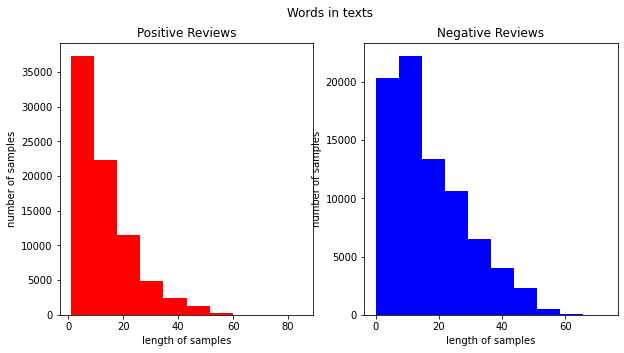

In [ ]:
# 길이 분포 확인
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
print(text_len)
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
print(text_len)
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [ ]:
# 부정 리뷰가 좀 더 길게 작성되는 경향이 있다.

In [ ]:
train_data['tokenized'].values

array([list(['바디', '버든', '줄이', '려고', '써', '보', '려고', '샀', '는데', '음용', '할', '수', '잇', '물', '로', '헹궈야', '되', '면', '왜', '식기세척기', '쓰', '나요']),
       list(['시중', '판매', '건', '새', '우랑', '다르', '속살', '고루', '분포', '된', '아니', '라', '속', '비', '어', '보이', '속살', '한쪽', '으로', '뭉쳐', '있', '어서', '씹', '때', '딱딱', '합니다', '믿', '먹', '어도', '되', '나', '의심', '드', '네요']),
       list(['깔끔', '니', '이쁘', '네요', '좋', '습니다']), ...,
       list(['장', '주문', '안', '됩니다', '장', '가능', '해요']),
       list(['하림', '치킨', '여기', '서', '구입', '니', '엄청', '저렴', '네요', '배송', '쾅', '꽝', '얼', '어서', '도착', '아주', '만족', '합니다', 'ㅋㅋ']),
       list(['조금', '약해', '보이', '는데', '저렴', '잘', '삿', '어요'])], dtype=object)

In [ ]:
train_data['label'].values

array([0, 0, 1, ..., 0, 1, 1])

In [ ]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

# 7. 정수 인코딩

* 기계가 텍스트를 숫자로 처리할 수 있도록 훈련데이터와 테스트 데이터에 정수 인코딩을 수행해야한다.

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 41176
등장 빈도가 1번 이하인 희귀 단어의 수: 18745
단어 집합에서 희귀 단어의 비율: 45.52409170390519
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7654538371512785


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 22433


In [ ]:
# 이제 단어 집합의 크기는 21,787개입니다. 이를 토크나이저의 인자로 넘겨주면, 토크나이저는 텍스트 시퀀스를 숫자 시퀀스로 변환합니다. 이러한 정수 인코딩 과정에서 이보다 큰 숫자가 부여된 단어들은 OOV로 변환하겠습니다.

tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(X_train[:3])

[[1979, 1, 2973, 149, 129, 41, 149, 70, 5, 10685, 61, 80, 256, 158, 31, 14710, 20, 47, 244, 5476, 24, 318], [2313, 502, 144, 320, 9314, 364, 9929, 6283, 11676, 215, 93, 56, 449, 133, 17, 239, 9929, 690, 34, 3791, 8, 48, 1181, 66, 564, 19, 241, 18, 390, 20, 33, 1355, 278, 2], [132, 59, 200, 2, 3, 12]]


In [ ]:
print(X_test[:3])

[[14, 712, 776, 115, 186, 253, 12], [349, 3935, 62, 3884, 1708], [11, 69, 2, 49, 165, 3, 27, 15, 6, 514, 289, 17, 92, 111, 559, 59, 7, 2]]


# 8. 패딩

리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 15.312544551855233


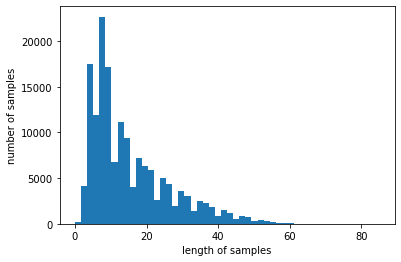

In [ ]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
# 최대 길이가 85이므로, 80의 길이로 패딩할 경우, 샘플이 보존되는 퍼센트


In [ ]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99874942160749


In [ ]:
# 최대 길이 80으로 패딩
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

# 9. RNN 으로 네이버 쇼핑 리뷰 감성 분류

In [57]:
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model,save_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [58]:
model=Sequential()
model.add(Embedding(vocab_size,100)) # 임베딩 벡터의 차원은 32
model.add(SimpleRNN(32)) # RNN 셀의 hidden_size는 32 ####
model.add(Dense(1,activation='sigmoid'))

In [59]:
# 최소화 시키는 방향으로 training 이 진행되므로 min 을 지정한다. 
# 아래와 같이 지정하면 validation set 의 loss 를 monitoring 한다는 뜻이다. 
# verbose =1 keras에서 training이 언제 멈추는지 화면에 출력됨.
# patience : 성능이 증가하지않는 것이 4번 지속되면 멈춤.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4) 


Model Choice



* Early stopping 객체에 의해 트레이닝이 중지되었을 때, 그 상태는 이전 모델에 비해 일반적으로 validation error 가 높은 상태일 것이다. 따라서, Earlystopping 을 하는 것은 특정 시점에 모델의 트레이닝을 멈춤으로써, 모델의 validation error 가 더 이상 낮아지지 않도록 조절할 수는 있겠지만, 중지된 상태가 최고의 모델은 아닐 것이다. 따라서 가장 validation performance 가 좋은 모델을 저장하는 것이 필요한데, keras 에서는 이를 위해 ModelCheckpoint 라고 하는 객체를 존재한다. 이 객체는 validation error 를 모니터링하면서, 이전 epoch 에 비해 validation performance 가 좋은 경우, 무조건 이 때의 parameter 들을 저장한다. 이를 통해 트레이닝이 중지되었을 때, 가장 validation performance 가 높았던 모델을 반환할 수 있다. 


In [60]:
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [61]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
2133/2133 [==============================] - 66s 30ms/step - loss: 0.2976 - acc: 0.8841 - val_loss: 0.2539 - val_acc: 0.9052

Epoch 00001: val_acc improved from -inf to 0.90521, saving model to best_model.h5
Epoch 2/15
2133/2133 [==============================] - 64s 30ms/step - loss: 0.2429 - acc: 0.9109 - val_loss: 0.2455 - val_acc: 0.9090

Epoch 00002: val_acc improved from 0.90521 to 0.90902, saving model to best_model.h5
Epoch 3/15
2133/2133 [==============================] - 64s 30ms/step - loss: 0.2232 - acc: 0.9200 - val_loss: 0.2422 - val_acc: 0.9121

Epoch 00003: val_acc improved from 0.90902 to 0.91212, saving model to best_model.h5
Epoch 4/15
2133/2133 [==============================] - 64s 30ms/step - loss: 0.2065 - acc: 0.9267 - val_loss: 0.2399 - val_acc: 0.9133

Epoch 00004: val_acc improved from 0.91212 to 0.91331, saving model to best_model.h5
Epoch 5/15
2133/2133 [==============================] - 64s 30ms/step - loss: 0.1929 - acc: 0.9319 - val_loss: 0.23

In [65]:
loaded_model = load_model('best_model.h5')
loaded_model.save('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1250/1250 [==============================] - 7s 6ms/step - loss: 0.2392 - acc: 0.9148

 테스트 정확도: 0.9148


In [70]:
# SavedModel로 전체 모델을 저장합니다
!mkdir -p saved_model
model.save('/content/drive/MyDrive/mymodel/model.h5') 

In [71]:
loaded_model2 = load_model('/content/drive/MyDrive/mymodel/model.h5')

In [72]:
def sentiment_predict(new_sentence):
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  print('pad_new :',pad_new)
  score = float(loaded_model2.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [73]:
sentiment_predict('이거 진짜 쓰레깁니다. 똥이에요 똥')

pad_new : [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0  227  107 6012 2314    1 1586   94 1586]]
96.59% 확률로 부정 리뷰입니다.


In [ ]:
sentiment_predict('와 진짜 대박 ㅋㅋ 너무 좋아용')

pad_new : [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0 107 741 185  14   3 455]]
99.15% 확률로 긍정 리뷰입니다.


In [ ]:
sentiment_predict('이딴걸 왜만듦?')

pad_new : [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0 2908  162  244   35 3992    1]]
98.92% 확률로 부정 리뷰입니다.
